In [1]:
import awkward as ak
import pandas as pd
import numpy as np

import uproot
#import ROOT

import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from matplotlib.patches import RegularPolygon
from matplotlib import colors

from scipy.optimize import minimize
from scipy.optimize import curve_fit

## Loading the dataset and visualization

The TB simulations are run with a fixed energy of the positrons. First, we are going to look at a positron shower in the CE-E section of the HGCAL. The absorber layers of the CE-E section are alternating plates
of either lead cladded with stainless steel or copper and copper-tungsten plates the active layers
are all segmented silicon HsiI sensors. The CE-E section in the prototype has 28 layer, each corresponding to roughly one radiation length ($X_{0}$).

We have skimmed the nTuples and stored them in pickle format. There are 5  quantities available for this exercise which are given as follows:

- rechit_x: x-coordinates of the reconstructed hits in the HGCAL
- rechit_y: y-coordinates of the reconstructed hits in the HGCAL
- rechit_z: z-coordinates of the reconstructed hits in the HGCAL
- rechit_energy: Calibrated energies of the hits in the HGCAL measured in the units of MIPs
- trueBeamEnergy: The truth value of the energy of the incoming positron

In [2]:
beamEnergy = 100
pickles = ['rechit_x', 'rechit_y', 'rechit_z', 'rechit_energy', 'trueBeamEnergy']

arrays = {}

path_to_pickles = '/eos/user/b/bjoshi/hgcal_electron_simulations/{}'.format(beamEnergy)
for p in pickles:
    with open('{}/{}.pickle'.format(path_to_pickles, p), 'rb') as f0:
        arrays[p]=pickle.load(f0)

Now that we have loaded all the data, let check the distribution of hits in the first layer. For that, first let us take a look at the positions of diffrent layers in CE-E section in the longitudnal direction.

In [3]:
layer_position = np.unique(ak.flatten(arrays['rechit_z']))[0:28] # get the positions of the layers

In [4]:
print('----------------------')
print(' Layer \t| z coord (cm)')
print('----------------------')
for il,l in enumerate(layer_position):
    print('  {}:\t|   {:0.2f}'.format(il+1, l))

----------------------
 Layer 	| z coord (cm)
----------------------
  1:	|   13.88
  2:	|   14.77
  3:	|   16.78
  4:	|   17.67
  5:	|   19.69
  6:	|   20.58
  7:	|   22.69
  8:	|   23.58
  9:	|   25.70
  10:	|   26.59
  11:	|   28.70
  12:	|   29.59
  13:	|   31.51
  14:	|   32.40
  15:	|   34.31
  16:	|   35.20
  17:	|   37.12
  18:	|   38.01
  19:	|   39.92
  20:	|   40.81
  21:	|   42.91
  22:	|   44.04
  23:	|   46.41
  24:	|   47.54
  25:	|   49.68
  26:	|   50.69
  27:	|   52.88
  28:	|   53.90


#### **Geometry of a cassette in CE-E**

<img src="cee_prototype_cassette.png" width="500px"/>

<Figure size 432x288 with 0 Axes>

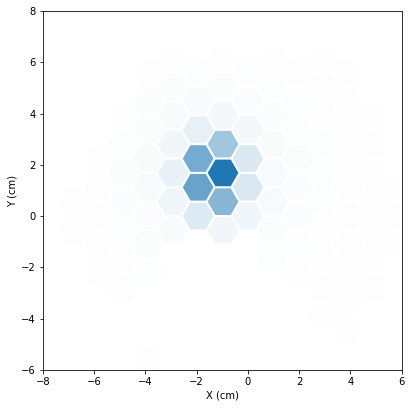

In [5]:
xarray = ak.flatten(arrays['rechit_x'][arrays['rechit_z']==layer_position[0]])
yarray = ak.flatten(arrays['rechit_y'][arrays['rechit_z']==layer_position[0]])

hit_map = pd.DataFrame(data = {'rechit_x': xarray, 'rechit_y':yarray})

# generate the permutations of the grid
tmp = hit_map.groupby(['rechit_x','rechit_y']).size()
sensor_xy = []
for key_ in tmp.keys():
    sensor_xy.append(key_)

sensor_density = np.array(tmp.values)
sensor_density = sensor_density/sensor_density.max()

# generate hexagonal grid with sensor as the center
plt.clf()
fig, ax = plt.subplots(1)
fig.set_figheight(6.6)
fig.set_figwidth(6.6)
ax.set_aspect('equal')

for ic, c in enumerate(sensor_xy):
    # fix radius here
    hexagon = RegularPolygon((c[0], c[1]), numVertices=6, edgecolor='none',
                             radius=0.6, alpha=sensor_density[ic], orientation=np.pi/6)
    ax.add_patch(hexagon)
plt.xlim([-8, 6])
plt.ylim([-6, 8])
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
plt.show()

### **Exercise (1)**:<br>
&emsp;(i) Make a similar plot of the tranverse distribution of hits in layer 10 and other layers.<br>
&emsp;(ii) Make a 3D event display showing the hits scattered in (x,y,z) coordinates. (**hint**: You can use plotly for rendering 3D displays)

## Shower Depth
Now, we are going to take a look at the distribution of hits in the shower as a function of the depth of the calorimeter. The higher the energy of the incoming particle, the deeper the is the shower. First, we group the hits by their layers in each event and calculate the mean energy and the error associated with it.

In [6]:
sum_e_layers = np.array([ ak.sum(arrays['rechit_energy'][((arrays['rechit_z']==lz)*(arrays['rechit_energy']>0.5))], axis=1) for lz in layer_position ])
nevents = sum_e_layers.shape[1]
totalEnergy = np.sum(sum_e_layers.T, axis=1)

meanEnergy = []
errEnergy = []
for lz in range(28):
    meanEnergy.append(sum_e_layers[lz,:].mean())
    errEnergy.append(sum_e_layers[lz,:].std()/np.sqrt(nevents))

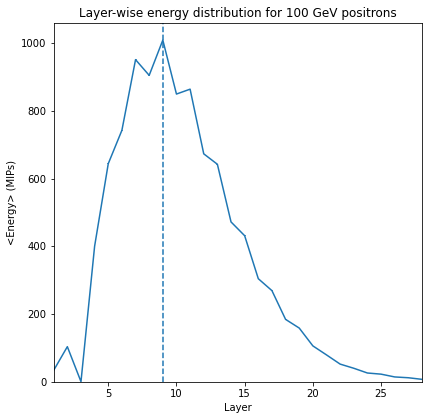

In [7]:
plt.figure(figsize=(6.6,6.6))
plt.errorbar(np.arange(1,29,1), meanEnergy, yerr=errEnergy)
plt.ylabel('<Energy> (MIPs)')
plt.xlabel('Layer')
plt.title('Layer-wise energy distribution for {} GeV positrons'.format(beamEnergy))
plt.ylim(0,1.05*max(meanEnergy))
plt.xlim(1, 28)

max_idx = meanEnergy.index(max(meanEnergy))
max_layer = np.arange(1,29,1)[max_idx]
plt.plot((max_layer,max_layer), (0, 1.05*max(meanEnergy)), '--', c='tab:blue')
plt.show()

An better way to understand the energy deposition is to plot the fraction of energy deposit as a function of the radiation lengths. For, that we can use the conversion table "cassette_info_cee.csv". The 28 layers are grouped into 14 different cassettes. The third column (dESi) gives the peak value of the simulated energy loss in the si sensor by a 150 GeV muon. The fourth column (z) and the fifth column (dz) gives the calorimeter depth before each sensor and the thickness between two sensors in units of radiation lengths. The last two columns give the enrgy loss in the absorber and the combined mean loss in absorber and silicon detector. For details, refer to: https://arxiv.org/pdf/2111.06855.pdf

In [8]:
cassette_info = pd.read_csv('cassette_info_cee.csv', delimiter='\t')
cassette_info.head()

,cas,layer,dESi,z,dz,dEAbs,mean_dE
0,1,1,0.085,1.00,1.00,10.2,11.25
1,1,2,0.085,1.98,0.98,12.3,9.85
2,2,3,0.085,2.92,0.94,7.4,9.85
3,2,4,0.085,3.90,0.98,12.3,9.85
4,3,5,0.085,4.84,0.94,7.4,9.85


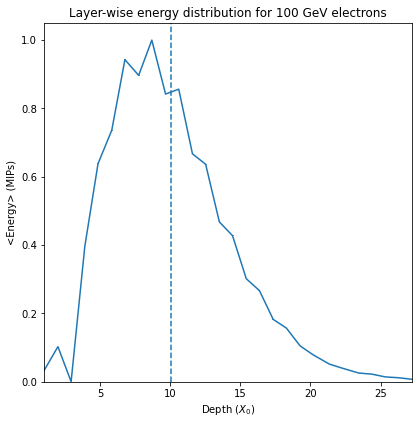

In [9]:
plt.figure(figsize=(6.6,6.6))
normMeanEnergy = meanEnergy/max(meanEnergy)
plt.errorbar(cassette_info['z'], normMeanEnergy, yerr=errEnergy/max(meanEnergy))
plt.ylabel('<Energy> (MIPs)')
plt.xlabel('Depth ($X_{0}$)')
plt.title('Layer-wise energy distribution for {} GeV electrons'.format(beamEnergy))
plt.ylim(0,1.05*max(normMeanEnergy))
max_idx = meanEnergy.index(max(meanEnergy))
max_z = cassette_info['z'][max_idx]
mean_depth = np.average(cassette_info['z'].values, weights=normMeanEnergy)
plt.plot((mean_depth, mean_depth), (0, 1.05*max(normMeanEnergy)), '--', c='tab:blue')
plt.xlim(1.00,27.28)
plt.show()

### **Exercise (2):** <br>
Make layer-wise energy distribution for different input beam energies, i.e. [20, 30, 50, 80, 100, 120, 150, 200, 250, 300]. Then, for each energy get measure the shower depth and plot them on a log scale.

In [ ]:
# energyList = [20, 30, 50, 80, 100, 120, 150, 200, 250, 300]
# def get_mean_energy_deposits(beamEnergy=100):
#    '''
#    Add your code here
#    '''
#   return (meanEnergy/max(meanEnergy), errEnergy/max(meanEnergy))
# plt.figure(figsize=(6.6,6.6))
# cmap = plt.get_cmap('plasma')
# cols = cmap.colors
# carray = []
# for i in range(len(energyList)):
#     carray.append(cols[int(256*float(i)/float(len(energyList))])
# plt.clf()
# plt.figure(figsize=(6.6,6.6))
# '''
# plot here
# '''
# plt.ylabel('<Energy> (MIPs)')
# plt.xlabel('Depth ($X_{0}$)')
# plt.title('Layer-wise energy distribution')
# plt.legend(loc='upper right')
# plt.ylim(0,1.05)
# plt.xlim(1.00,27.28)
# plt.show()

#### What you should expect

**Figure (1):** Distribution of layer-wise energies for different energies of input positron energies

<figure>
   <td style='text-align:center;'>
       <img src="electron_energy_distribution_example.png" style="width:100%">
   </td>
</figure>

**Figure (2):** Depth of the shower as a function of beam energy on a logarithmic scale.<br>
**Question:** Why is it linear?

<img src="electron_shower_depth_example.png"/>

## Energy Resolution

Energy resolution of a calorimeter quantifies it's ability to precisely measure the energy of incoming particles.
For the HGCAL prototype, the resolution can be defined as follows:<br>
$$\dfrac{\sigma}{E} = \dfrac{a}{\sqrt(E)}+c$$<br>
where a is the *stochastic* term and c is the constant term. The *stochastic* term reflects the fluctuations in the number of signal generating processes. Since the number of photons/electrons generated in each absorber layer is a statistical process, the measured energy also varies accordingly. The *constant* term arises from the imperfections in the detector. These include, errors is channel to channel intercalibrations, differences in the dimensions of the detector material, energy lost in the dead detector material and impoerfections in logitudnal confinement of the shower. A lower *constant* term is a "hallmark" of a good calorimeter.<br><br>
Note: Another *noise* term is added to the resolution to account for the effects from pile-up.

### Calculating the resolution

We assume that the energy distrbution of all rechits within an event follows a Gaussian distribution with mean as the energy of the incoming particle. The ratio of standard deviation to the mean gives us the value of the resolution. In the following exmaple we make a simple distribution of the sum of reconstructed hit energies produced by a 100 GeV positron. The distribution will be made in the units of MIPs, but since we are only taking the ratio, the unit doesn't matter in this case.

In [10]:
def GausPDF(x, *c):
    '''
    Gaussian PDF for fitting the curve
    '''
    A = c[0] # fraction of crystalball
    #define function parameters
    mu = c[1]
    sigma = c[2]
    z = (x-mu)/sigma
    G = A*(1/np.sqrt(2*(sigma**2)*np.pi))*np.exp(-(z**2)/2)
    return G

Using the *curve_fit* package from *SciPy* library, we find the best fit of the mean and std. deviation for the data.

<Figure size 432x288 with 0 Axes>

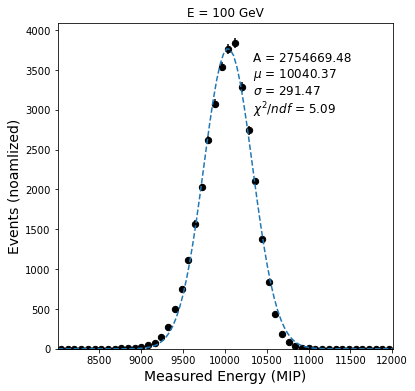

In [11]:
earray = ak.sum(arrays['rechit_energy'], axis=1)
earray = earray[earray>0]

nsigma=3.0
plt.clf()
plt.figure(figsize=(6,6))
mean_ = np.mean(earray)
std_ = np.std(earray)

# plot data
data_range = (mean_-2e3, mean_+2e3)
M = np.linspace(data_range[0], data_range[1], 100)

data_hist2_array = plt.hist(earray,
         histtype='step', color='w', linewidth=0,
         range=data_range, bins=50)

xarray = (data_hist2_array[1][1:]+data_hist2_array[1][:-1])/2
yarray = data_hist2_array[0]

plt.scatter(xarray, yarray, marker='o', c='black', s=40)
plt.bar(xarray, yarray, width=0.05, color='none', yerr=np.sqrt(yarray))

results = curve_fit(GausPDF, xarray, yarray, 
                p0=(max(yarray), mean_, std_))
E = yarray-np.array([ GausPDF(m, *results[0]) for m in xarray])
E = E/(np.sqrt(yarray+0.001))
chi2 = np.sqrt(sum(E**2)/(len(E)-1))

plt.plot(M, [ GausPDF(m, *results[0]) for m in M], linestyle='dashed')

# plot data
plt.xlim(data_range)
plt.ylabel('Events (noamlized)', size=14)
plt.xlabel('Measured Energy (MIP)', size=14)
stat_text = '''
A = {:0.2f}
$\mu$ = {:0.2f}
$\sigma$ = {:0.2f}
$\chi^2/ndf$ = {:0.2f}
'''.format(results[0][0], results[0][1], abs(results[0][2]), chi2)
stat_text_box = plt.text(x=mean_+0.25*nsigma*std_, y=0.7*max(yarray),
    s=stat_text,
    fontsize=12,
    fontfamily='sans-serif',
    horizontalalignment='left', 
    verticalalignment='bottom')
plt.title('E = {} GeV'.format(beamEnergy))
plt.show()

### **Exercise (3)**:<br>
&emsp;(i) Plot distributions for all the energies ranging from [20, 300]. Determine resolution by fitting each distribution separately with a Gaussian PDF.<br>
&emsp;(ii) Fit the resolution as a function of Beam Energy using the formula of the resolution mentioned at the begining of this section.<br>
&emsp;(iii) Find the *stochastic* and *constant* terms for CE-E section of the HGCAL prototype.